# Twitter Sentiment Trading Strategy

## 1. Load Twitter Sentiment Data

In [9]:
# Load twitter sentiment dataset, set the index, calculate engagement ratio, and filter out stocks with no significant twitter activity.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')
data_folder = '/Users/vishnu/home/resume_projects/TradingAlgorithm'
sentiment_df = pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df = sentiment_df.set_index(['date', 'symbol'])
sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

# Filtering Only Stocks That Have 20+ Likes and 10+ Comments
sentiment_df = sentiment_df[(sentiment_df['twitterLikes'] > 20) & (sentiment_df['twitterLikes']>10)]
sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 TMO             21.0              2.0          32.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 TMO                30857.0          0.610020          0.062500  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[26112 rows x 6 columns]

## 2. Aggregate Monthly and Calculate Average Sentiment for the Month

In [17]:
# Aggregate on a montly level and calculating average monthly metrics for chosen stocks
aggregated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
 [['engagement_ratio']].mean())

# Stocks with highest engagement ratio have lowest rank
aggregated_df['rank'] = (aggregated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

aggregated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  38.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.285456  17.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.243042  39.0
           TSLA            0.151992  73.0
           TSN             0.280553  27.0
           V               0.194045  61.0
           XOM             0.217904  52.0

[1112 rows x 2 columns]

## 3. Select Top 5 Stocks Based on Cross-Sectional Ranking for Each Month

In [28]:
# Select Top 5 Stocks by rank for each month and fix the date to start at beginning of next month.
filtered_df = aggregated_df[aggregated_df['rank']<6].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index+pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])
filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 FCX             0.841220   4.0
           ILMN            0.741935   5.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.037446   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           MRO             0.581748   4.0
           OXY             1.025579   3.0

# 4. Extract the stocks to form portfolios at the start of each new month

In [30]:
# Create a dictionary containing start of month and correspond selected stocks.
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['FCX', 'ILMN', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['DD', 'JPM', 'META', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DAL', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['AES', 'BIIB', 'FCX', 'GILD', 'MDT']}

## 5. Download fresh stock prices for only selected/shortlisted stocks

In [32]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()
prices_df = yf.download(tickers=stocks_list, 
                        start='2021-01-01',
                        end='2023-03-01')

[**********************65%%*****                 ]  55 of 85 completed

$GOOG: possibly delisted; No price data found  (1d 2021-01-01 -> 2023-03-01)


[**********************80%%************          ]  68 of 85 completed

$EL: possibly delisted; No price data found  (1d 2021-01-01 -> 2023-03-01)


[*********************100%%**********************]  85 of 85 completed

3 Failed downloads:
['ATVI']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['GOOG', 'EL']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2021-01-01 -> 2023-03-01)')


## 6. Calculate Portfolio Returns with monthly rebalancing

In [46]:
returns_df = np.log(prices_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()
for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    cols = fixed_dates[start_date]
    print(cols)
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
portfolio_df

['AES', 'FCX', 'MNST', 'OXY', 'SLB']
['FCX', 'ILMN', 'L', 'LUV', 'MA']
['AMD', 'D', 'FCX', 'LUV', 'MA']
['FCX', 'GILD', 'LUV', 'MRO', 'OXY']
['A', 'CRM', 'PFE', 'PM', 'STZ']
['AMD', 'CRM', 'CVX', 'J', 'KEY']
['AMD', 'DD', 'FCX', 'KEY', 'LMT']
['CB', 'CRM', 'DD', 'FCX', 'STZ']
['DD', 'JPM', 'META', 'REGN', 'STZ']
['ABT', 'DIS', 'L', 'META', 'MRNA']
['J', 'KEY', 'L', 'META', 'MU']
['A', 'DD', 'FCX', 'J', 'META']
['AEP', 'AES', 'DAL', 'J', 'STZ']
['A', 'AES', 'DAL', 'J', 'KEY']
['AES', 'BIIB', 'FCX', 'GILD', 'MDT']


,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.008705
2023-02-23,-0.011206
2023-02-24,-0.011258


## 7. Download NASDAQ/QQQ Prices and Caluclate Returns to Compare to Our Strategy

In [48]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')
qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')
portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)
portfolio_df


[*********************100%%**********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017541
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.008705,0.000748
2023-02-23,-0.011206,0.008696
2023-02-24,-0.011258,-0.016886


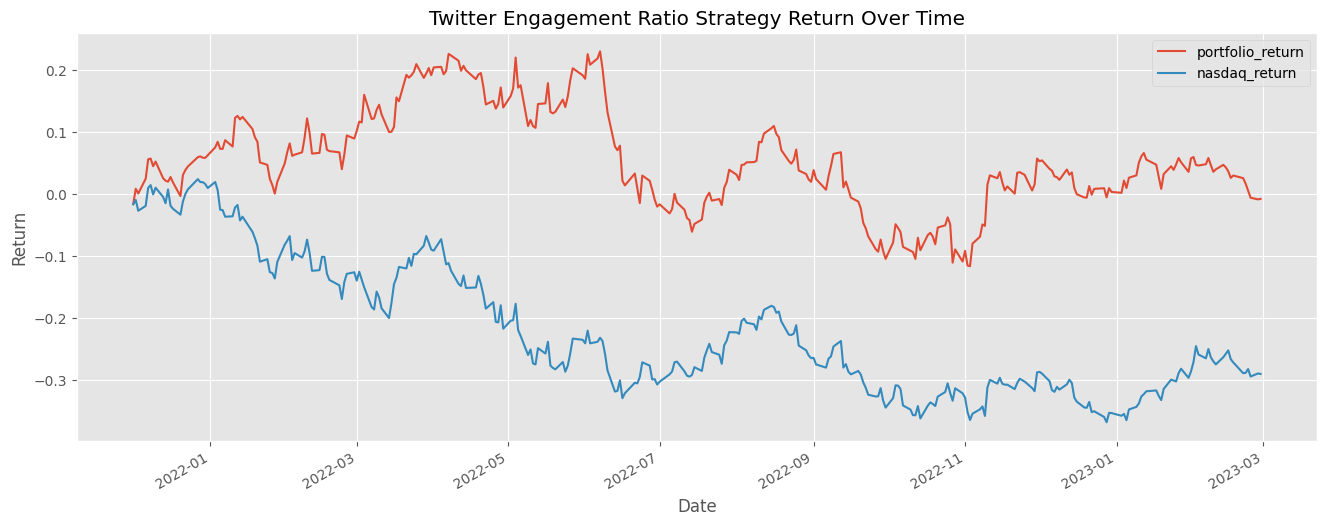

In [50]:
# Visualizing Portfolio Return in comparison to NASDAQ Return
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)
portfolio_cumulative_return.plot(figsize=(16,6))
plt.title('Twitter Engagement Ratio Strategy Return Over Time')
plt.ylabel('Return')
plt.show()